In [1]:
from dimod import BinaryQuadraticModel, BINARY
from dwave.cloud import Client

# client = Client.from_config(token = 'YOUR TOKEN')
# client.get_solvers()

FIRST_TYPE = 1
SECOND_TYPE = 2
THIRD_TYPE = 3
TYPES_OF_CONTAINERS = [FIRST_TYPE, SECOND_TYPE, THIRD_TYPE]

class Container:
    def __init__(self, _id=None, type_of_container=FIRST_TYPE, mass=0):
        self._id = _id
        self.mass = mass
        if type_of_container not in TYPES_OF_CONTAINERS:
            raise ValueError
        self.type_of_container = type_of_container
        
def sum_of_bqm(bqm1: BinaryQuadraticModel, bqm2: BinaryQuadraticModel):
    """
    Warning! bqm1 will be changed
    """
    bqm1.add_variables_from(bqm2.linear)
    bqm1.add_interactions_from(bqm2.quadratic)
    bqm1.add_offset(bqm2.offset)

    return bqm1

In [123]:
def func(container, k):
    if container.type_of_container == FIRST_TYPE:
        if k >= 0:
            return k
        else:
            return k
    elif container.type_of_container == THIRD_TYPE:
        if k >= 0:
            return 0.5*(k)
        else:
            return 0.5*(k)
    else:
        raise NotImplementedError


def make_bqm_for_centre_of_gravity(containers, L=10, mass_of_aircraft=0, centre_gravity_of_aircraft=0, main_center=0,
                                   lambda_1=1,
                                   lambda_3=1, lambda_4=1, lambda_5=3, lambda_6=1):
    if any(container.type_of_container == SECOND_TYPE for container in containers):
        raise ValueError("We can't work with the second type of container")
    
    N = len(containers)
    
    full_mass = sum(map(lambda x: x.mass, containers)) + mass_of_aircraft
    center = mass_of_aircraft*centre_gravity_of_aircraft - full_mass*main_center
    center /= full_mass
    
    bqm = BinaryQuadraticModel({}, {}, 0, BINARY)
    
    # center of gravity
    bqm.add_offset(center**2*lambda_1)
    for i in range(N):
        for k in range(-L, L+1):
            bqm.add_variable(i*N + k, 2*center*func(containers[i], k)*containers[i].mass/full_mass*lambda_1)
            
    for i in range(N):
        for k in range(-L, L+1):
            bqm.add_variable(i*N + k, (func(containers[i], k)*containers[i].mass/full_mass)**2*lambda_1)
            
    for i1 in range(N):
        for i2 in range(N):
            for k1 in range(-L, L+1):
                for k2 in range(-L, L + 1):
                    if i1*N + k1 <= i2*N + k2:
                        continue
                        
                    bqm.add_interaction(
                        i1*N + k1, i2*N + k2,
                        2*func(containers[i1], k1)*containers[i1].mass*func(containers[i2], k2)*containers[i2].mass/full_mass**2*lambda_1
                    )
    
    # lambda_3
    for k in range(-L, L+1):
        for i1 in range(N):
            for i2 in range(i1 + 1, N):
                bqm.add_interaction(i1*N + k, i2*N + k, 2*lambda_3)
    
    # lambda_4
    for i in range(N):
        if containers[i].type_of_container != FIRST_TYPE:
            continue
        for k in range(-L, L+1):
            bqm.add_variable(i*N + k, -lambda_4)
        
        for k1 in range(-L, L+1):
            for k2 in range(k1 + 1, L+1):
                bqm.add_interaction(i*N + k1, i*N + k2, 2*lambda_4)
        bqm.add_offset(lambda_4)
        
    # lambda_5
    for i in range(N):
        if containers[i].type_of_container != THIRD_TYPE:
            continue
            
        bqm.add_offset(lambda_5)
        for k in range(-L, L+1):
            bqm.add_variable(i*N + k, -3*lambda_5)
            
        for k1 in range(-L, L+1):
            for k2 in range(k1+1, L+1):
                bqm.add_interaction(i*N + k1, i*N + k2, 2*lambda_5)
                
    for i in range(N):
        if containers[i].type_of_container != THIRD_TYPE:
            continue
            
        for k in range(-L, L):
            bqm.add_interaction(i*N + k, i*N + k + 1, -lambda_6)
    
    
                    
    return bqm

In [129]:
import pandas as pd

data = pd.read_csv('ds3.csv', sep=',')
data

,Container ID,Container type,Container mass (kg)
0,2.0,1.0,3455.0
1,3.0,1.0,1866.0
2,5.0,1.0,3500.0
3,6.0,1.0,3332.0
4,7.0,1.0,2578.0
5,8.0,1.0,2315.0
6,9.0,1.0,1888.0
7,10.0,1.0,1786.0
8,12.0,1.0,2987.0
9,13.0,1.0,2534.0


In [130]:
containers = []
for row in list(data.itertuples()):
    if row[2] == 2:
        continue
    containers.append(Container(*row[1:]))
# containers = containers[:1]
    
L = 10
mass_of_aircraft = 120*10**3
centre_gravity_of_aircraft= -0.05*2*L
main_center=0.1*2*L

bqm = make_bqm_for_centre_of_gravity(
    containers, L=L, mass_of_aircraft=mass_of_aircraft, centre_gravity_of_aircraft=centre_gravity_of_aircraft,
    main_center=main_center
)
print(list(bqm.variables))
print(len(list(bqm.variables)))

[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213

In [131]:
from dwave.system.samplers import DWaveSampler  
from dwave.system import EmbeddingComposite
from tools import get_response

from sa_by_isakov_solver import SaByIsakovSolver
from datetime import datetime

# sampler = EmbeddingComposite(DWaveSampler())
sampler = SaByIsakovSolver(name=f"airbus_{len(containers)}_containers_{L}_cells", num_sweeps=10**3, num_rep=10**3)
response = sampler.sample(bqm)
response = get_response(response)

print(response)
raw_results, energy = response[0]['results'], response[0]['min_energy']

[{'results': {-10: 1, -9: 0, -8: 0, -7: 0, -6: 0, -5: 0, -4: 0, -3: 0, -2: 0, -1: 0, 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 1, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 1, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 1, 51: 0, 52: 0, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 0, 60: 0, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 0, 69: 0, 70: 0, 71: 1, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 1, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0, 100: 1, 101: 0, 102: 0, 103: 0, 104: 0, 105: 0, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 0, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 0, 120: 0, 121: 0, 122: 0, 123: 0, 124: 0, 125: 0, 126: 0, 127: 1, 1

In [132]:
import numpy as np

N = len(containers)
results = np.zeros((N, 2*L + 1))

for i in range(N):
    for k in range(-L, L+1):
        results[i, k + L] = raw_results[i*N + k]
        
print(results)

exp_center = 0
for i in range(N):
    for k in range(-L, L+1):
        exp_center += containers[i].mass * results[i, k + L] * func(containers[i], k)
        
exp_center += mass_of_aircraft*centre_gravity_of_aircraft
full_mass = sum(map(lambda x: x.mass, containers)) + mass_of_aircraft
exp_center /= full_mass
print(exp_center/L/2)
print(exp_center/L/2 - main_center/L/2)
print(results[5, :])
print(main_center)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0.

In [133]:
table_containers = []
for k in range(-L, L + 1):
    ids = []
    for i in range(N):
        if results[i, k + L] == 1:
            ids.append(containers[i]._id)
    table_containers.append(ids)
table_containers

[['2.0'],
 ['12.0'],
 ['21_24'],
 [],
 ['3.0'],
 ['13.0'],
 ['5.0'],
 ['15.0'],
 ['9.0'],
 ['6.0'],
 ['25_27'],
 [],
 ['8.0'],
 ['7.0'],
 ['14.0'],
 ['29_30'],
 ['40'],
 ['40'],
 ['10.0'],
 ['17.0'],
 []]



  0%|          | 0/61 [00:00<?, ?it/s]

  2%|▏         | 1/61 [00:03<03:21,  3.36s/it]

  3%|▎         | 2/61 [00:06<03:12,  3.25s/it]

  5%|▍         | 3/61 [00:09<03:04,  3.18s/it]

  7%|▋         | 4/61 [00:12<02:59,  3.14s/it]

  8%|▊         | 5/61 [00:15<02:54,  3.11s/it]

 10%|▉         | 6/61 [00:18<02:49,  3.07s/it]

 11%|█▏        | 7/61 [00:21<02:51,  3.17s/it]

 13%|█▎        | 8/61 [00:25<02:57,  3.35s/it]

 15%|█▍        | 9/61 [00:28<02:52,  3.32s/it]

 16%|█▋        | 10/61 [00:31<02:46,  3.26s/it]

 18%|█▊        | 11/61 [00:35<02:41,  3.23s/it]

 20%|█▉        | 12/61 [00:38<02:34,  3.16s/it]

 21%|██▏       | 13/61 [00:41<02:29,  3.11s/it]

 23%|██▎       | 14/61 [00:44<02:26,  3.12s/it]

 25%|██▍       | 15/61 [00:47<02:22,  3.10s/it]

 26%|██▌       | 16/61 [00:50<02:18,  3.09s/it]

 28%|██▊       | 17/61 [00:53<02:16,  3.10s/it]

 30%|██▉       | 18/61 [00:56<02:13,  3.11s/it]

 31%|███       | 19/61 [00:59<02:10,  3.10s/it]

 33%|███▎      | 20/61 [01:02<02:07,

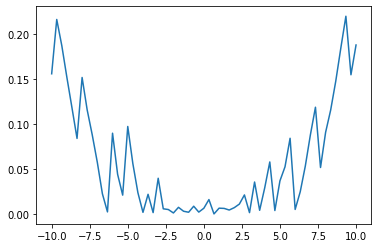

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
from sa_by_isakov_solver import SaByIsakovSolver
from tools import get_response
from tqdm import tqdm
import numpy as np
import pandas as pd

def find_target_center(results, containers, L, mass_of_aircraft, centre_gravity_of_aircraft):
    exp_center = 0
    for i in range(len(containers)):
        for k in range(-L, L+1):
            exp_center += containers[i].mass * results[i, k + L] * func(containers[i], k)

    exp_center += mass_of_aircraft*centre_gravity_of_aircraft
    full_mass = sum(map(lambda x: x.mass, containers)) + mass_of_aircraft
    exp_center /= full_mass
    
    return exp_center

def make_graphics(solver, containers, L, mass_of_aircraft, centre_gravity_of_aircraft):
    target_center_array = np.array([t/3 for t in range(-3*L, 3*L + 1)])
    error_array = np.zeros((len(target_center_array), ))
    N = len(containers)
    
    for i_target, target_center in enumerate(tqdm(target_center_array)):
        bqm = make_bqm_for_centre_of_gravity(containers, L, mass_of_aircraft, centre_gravity_of_aircraft, target_center)
        
        response = sampler.sample(bqm)
        response = get_response(response)
        raw_results, energy = response[0]['results'], response[0]['min_energy']
        
        results = np.zeros((N, 2*L + 1))
        for i in range(N):
            for k in range(-L, L+1):
                results[i, k + L] = raw_results[i*N + k]
                
        exp_center = find_target_center(results, containers, L, mass_of_aircraft, centre_gravity_of_aircraft)
        error_array[i_target] = np.abs((exp_center - target_center) / L)
    
    plt.plot(target_center_array, error_array)
    plt.show()
    
    return target_center_array, error_array

data = pd.read_csv('data.csv', sep=';')
containers = []
for row in list(data.itertuples()):
    if row[2] == 2:
        continue
    containers.append(Container(*row[1:]))
containers = containers[:16]
    
L = 10
mass_of_aircraft = 120*10**3
centre_gravity_of_aircraft= -0.05*L
main_center=0.1*L

sampler = SaByIsakovSolver(name=f"airbus_{len(containers)}_containers_{L}_cells", num_sweeps=10**3, num_rep=10**2)
x_array, y_array = make_graphics(sampler, containers, L, mass_of_aircraft, centre_gravity_of_aircraft)

In [28]:
list(zip(list(x_array), list(y_array)))

[(-10.0, 0.15593976377603394),
 (-9.666666666666666, 0.21633167588076194),
 (-9.333333333333334, 0.18715281988785337),
 (-9.0, 0.1519251987020401),
 (-8.666666666666666, 0.11823572505415551),
 (-8.333333333333334, 0.08408746932332356),
 (-8.0, 0.15184030478985058),
 (-7.666666666666667, 0.11580426875381455),
 (-7.333333333333333, 0.08799258928404159),
 (-7.0, 0.0574716995642901),
 (-6.666666666666667, 0.022566497766235115),
 (-6.333333333333333, 0.0024164692217664373),
 (-6.0, 0.08989170849737774),
 (-5.666666666666667, 0.04419048576868434),
 (-5.333333333333333, 0.021054774814214382),
 (-5.0, 0.09736503494848688),
 (-4.666666666666667, 0.05622441966975185),
 (-4.333333333333333, 0.02375806911212406),
 (-4.0, 0.0019102609230659874),
 (-3.6666666666666665, 0.021972831976115305),
 (-3.3333333333333335, 0.0016350705526583908),
 (-3.0, 0.03979986334150722),
 (-2.6666666666666665, 0.0058586659330885915),
 (-2.3333333333333335, 0.005041968749969161),
 (-2.0, 0.0012364339824118664),
 (-1.6666

In [ ]:
exp

In [20]:
y_array

array([104.71137282])

In [5]:
plt.show()

In [18]:
x_array, y_array

(array([-10.        ,  -9.66666667,  -9.33333333,  -9.        ,
         -8.66666667,  -8.33333333,  -8.        ,  -7.66666667,
         -7.33333333,  -7.        ,  -6.66666667,  -6.33333333,
         -6.        ,  -5.66666667,  -5.33333333,  -5.        ,
         -4.66666667,  -4.33333333,  -4.        ,  -3.66666667,
         -3.33333333,  -3.        ,  -2.66666667,  -2.33333333,
         -2.        ,  -1.66666667,  -1.33333333,  -1.        ,
         -0.66666667,  -0.33333333,   0.        ,   0.33333333,
          0.66666667,   1.        ,   1.33333333,   1.66666667,
          2.        ,   2.33333333,   2.66666667,   3.        ,
          3.33333333,   3.66666667,   4.        ,   4.33333333,
          4.66666667,   5.        ,   5.33333333,   5.66666667,
          6.        ,   6.33333333,   6.66666667,   7.        ,
          7.33333333,   7.66666667,   8.        ,   8.33333333,
          8.66666667,   9.        ,   9.33333333,   9.66666667,
         10.        ]),
 array([0.883440

In [9]:
list(map(lambda x: x.mass, containers))

[2134,
 3455,
 1866,
 1699,
 3500,
 70000,
 3332,
 2578,
 2315,
 1888,
 1786,
 3277,
 2987,
 2534,
 2111,
 2607,
 1566,
 1765,
 1946,
 1732,
 1641]